# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [15]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimesions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


In [83]:
import os
import numpy as np

all_left_coefficients = np.empty([0,2])
all_right_coefficients = np.empty([0,2])
recent_hough_lines = []

def clear_globals():
    global recent_hough_lines, all_left_coefficients, all_right_coefficients
    all_left_coefficients = np.empty([0,2])
    all_right_coefficients = np.empty([0,2])
    recent_hough_lines = []

def process_image(img):
    pre_processed_image = preprocess_image(img)
    lane_lines = detect_lane_lines(pre_processed_image)
    line_img = np.zeros((img.shape), dtype=np.uint8)
    drawn_lines = draw_lines(line_img, lane_lines)
    weighted_image = weighted_img(line_img, img)
    return weighted_image

def preprocess_image(img):
    gray_img = grayscale(img)
    kernel_size = 5
    blurred_image = cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)
    return blurred_image

def grayscale(image):
    #RGB limits
    lower = np.array([80,80,40])
    upper = np.array([255,255,80])
    mask = cv2.inRange(image, lower, upper)
    res = cv2.bitwise_and(image,image, mask= mask)
    res = cv2.addWeighted(res, 1.0, image, 1.0, 0)
    return cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    
    
def detect_lane_lines(img):
    global recent_hough_lines
    edges = canny(img)
    masked_edges = get_masked_image(edges)
    current_lines = get_hough_lines(masked_edges)
    recent_hough_lines.append(current_lines)
    return recent_hough_lines[-5:]

def draw_lines(img, lane_lines):
    coefficients = extract_image_intercepts(lane_lines)
    left_coefficients, right_coefficients = divide_and_average(coefficients)
    draw_line(left_coefficients, img)
    draw_line(right_coefficients, img)
    return img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

def canny(img):
    low_threshold = 50
    high_threshold = 150
    return cv2.Canny(img, low_threshold, high_threshold)

def get_masked_image(img):
    imshape = img.shape
    vertices = get_vertices(imshape[0], imshape[1])
    return region_of_interest(img, vertices)

def get_hough_lines(img):
    rho = 2
    theta = np.pi/180.
    threshold = 50
    min_line_length = 100
    max_line_gap = 160
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)
    
def extract_image_intercepts(images):
    m_and_b = np.empty([0,2])
    
    for lines in images:
        image_coefficients = extract_line_intercepts(lines)
        m_and_b = np.append(m_and_b, image_coefficients, axis=0)
        
    return m_and_b
    
def extract_line_intercepts(lines):
    m_and_b = np.empty([0,2])
    
    for line in lines:
        x1,y1,x2,y2 = line[0]
        m = get_slope(line[0])
        b = y1 - (m*x1)
        m_and_b = np.append(m_and_b, np.array([[m,b]]), axis=0) 

    return m_and_b

def divide_and_average(coefficients):
    global all_left_coefficients, all_right_coefficients
    m = coefficients[:,0]
    
    left_coefficients = coefficients[m < 0]
    left_averaged = average(left_coefficients, np.array(all_left_coefficients))
    all_left_coefficients = np.append(all_left_coefficients, np.array([left_averaged]), axis=0)
    all_left_coefficients = remove_outliers(all_left_coefficients)
    last_cleaned_left_coefficient = all_left_coefficients[-1,:]
    right_coefficients = coefficients[m > 0] 
    right_averaged = average(right_coefficients, np.array(all_right_coefficients))
    all_right_coefficients = np.append(all_right_coefficients, np.array([right_averaged]), axis=0)
    all_right_coefficients = remove_outliers(all_right_coefficients)
    last_cleaned_right_coefficient = all_right_coefficients[-1,:]
    
    return last_cleaned_left_coefficient, last_cleaned_right_coefficient

def draw_line(coefficients, img, color=[255, 0, 0], thickness=10):
    m = coefficients[0]
    b = coefficients[1]
    draw_coordinates = get_final_coordinates(m, b, img.shape[0])
    cv2.line(img, draw_coordinates[0], draw_coordinates[1], [255, 0, 0], thickness=10)

def get_vertices(image_height, image_width):    
    left_top = [image_width/2 * .98, image_height/2 * 1.16]
    right_top = [image_width/2 * 1.02, image_height/2 * 1.16]
    left_bottom = [0, image_height * .85]
    right_bottom = [image_width, image_height * .85]
    return np.array([[(left_top), (left_bottom), (right_bottom), (right_top)]], np.int32)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
          
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_slope(coordinates):
    x1,y1,x2,y2 = coordinates
    return (y2-y1) / (x2-x1)

def average(coefficients, all_coefficients):

    if len(coefficients) == 0:
        return all_coefficients[-1,:]
        
    cleaned_coefficients = remove_outliers(coefficients)
    averaged_coefficients = np.mean(cleaned_coefficients, axis=0)
    weighted_coefficients = weight(averaged_coefficients, all_coefficients)
    return weighted_coefficients
    
def remove_outliers(coefficients):
    
    if(len(coefficients) < 3):
        return coefficients

    m_coefficients = coefficients[:,0]
    b_coefficients = coefficients[:,1]
    return coefficients[np.logical_and(check_for_outliers(m_coefficients), check_for_outliers(b_coefficients))]

def check_for_outliers(coefficient_values):
    
    if len(coefficient_values) < 3:
        return True
    
    return abs(coefficient_values - np.mean(coefficient_values)) < (3 * np.std(coefficient_values))

def get_final_coordinates(slope, y_intercept, img_height):
    y1 = int(img_height)
    x1 = int((y1 - y_intercept) / slope)
    y2 = int((img_height / 2) * 1.20)
    x2 = int((y2 - y_intercept) / slope)
    return [(x1, y1), (x2, y2)]

def weight(averaged_coefficients, all_coefficients):
    weight = .4
    m, b = averaged_coefficients
    if len(all_coefficients) > 3:
        all_m, all_b = all_coefficients[:,0], all_coefficients[:,1]
        m = weight*m + (1-weight)*np.mean(all_m[len(all_m)-5:])
        b = weight*b + (1-weight)*np.mean(all_b[len(all_b)-5:])
    
    return [m, b]

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


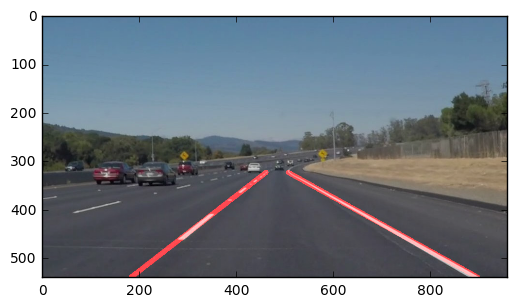

In [84]:
image_names = os.listdir("test_images/")
images = []

for name in image_names:
    clear_globals()
    img = mpimg.imread('test_images/' + name)
    processed_image = process_image(img)
    images.append(processed_image)
    
print('This image is:', type(images[0]), 'with dimesions:', images[0].shape)
plt.imshow(images[0])


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [78]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [79]:
clear_globals()
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 75.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [85]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 66.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.31 s, sys: 2.02 s, total: 11.3 s
Wall time: 10.6 s


In [86]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

In my lane finding pipeline, although I strived for simplicity and execution, there are some shortcomings that I believe could be improved.

While I was building, I noticed that although the still image looked great, the video would show my lines were flickering on and off, and the slope and positions of the lines would be jumping from frame to frame. I realized that the flickering was caused by insufficient data in specific frames where the hough line algorithm did not find many lines in that particular frame. I also found that each frame would have variance in the slopes of the images found, which would cause the lines to move significantly from one frame to another.

To solve the flickering issue, I compounded the current frame's houghlines with the hough lines of the previous 30 frames. 30 frames seemed to be the sweet spot for optimal to remove the flickering without slowing the processing down. By compounding the frames' lines, there was now plenty of data so that a left and right line appeared on every frame. 

For the line jumping issue, where it moved significantly from frame to frame, I had to do a few things. I seperated all left and right coordinates, and took the slope of each line of a frame and compare it to list of final average slopes of all the past frames in order to remove outliers. Once I had non-outlier coordinates, I averaged the coordinates of the lines of that one frame, and got a weight average of the frames slopes combined with average slopes of the past 10 frames. With the average coordinates and the weighted average slopes, I was able to get the y intercept, and generate coordinates to draw. But before drawing these coordinates, I got weighed average coordinates with the current frame and the past 10 frames to smooth out any large differences between frames. This resulted in a non-jumpy line that smoothly adjusted to directions of the lane lines.

I have identified a few weaknesses where my algorithm can be improved. When a video first starts off, since we don't have previous frames to weigh and measure current frame coordinates, the lines can be off on the first frame. As the car drives, it corrects itself, but this is an issue that I couldn't figure out. Since I am using the previous 30 frames, I worry that if there were a sharp turn in the road, my algorithm might not adjust fast enough. Right now, I am using percentages of the images height to calculate the bottom and top of my image masking. If there is a certain rise or fall in the elevation of the road, the lane lines may fall mostly on the outside of my masked image, causing my line detection to fail. Much of this assignment assumes decent weather and and road where road lines are clearly visible, which isn't necessarily real world. Since I am relying so heavily on edge detection, any thing that would disrupt the visibility of the road edges, like inclement weather, similar colored road pavement, or fading lines, I assume that my algorithm would fail.

In order to make this work better, I would like to learn how to dynamically modify the image masking (perhaps I could have done that with global variables). I'd like to be able to draw curved lines to follow turns in the road. And I am excited about the prospect of using more sensors to provide more data for when the lines are difficult to see.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [87]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 37.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.85 s, sys: 1.36 s, total: 8.21 s
Wall time: 8.43 s


In [88]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))